In [169]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import os
from selenium import webdriver
import time
import soupsieve
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet


In [46]:
#df = pd.read_csv ('beer_data.csv')
df = pd.read_csv ('beer_upload.csv')

In [47]:
df.head

<bound method NDFrame.head of                                                    name  score  rating  \
0     https://www.ratebeer.com/beer/harviestoun-ola-...   99.0    3.90   
1     https://www.ratebeer.com/beer/st-bernardus-wit...   90.0    3.63   
2     https://www.ratebeer.com/beer/the-bruery-three...  100.0    4.18   
3     https://www.ratebeer.com/beer/night-shift-bean...   97.0    3.90   
4     https://www.ratebeer.com/beer/omnipollo-siren-...  100.0    4.23   
...                                                 ...    ...     ...   
6841  https://www.ratebeer.com/beer/de-la-senne-witt...   90.0    3.75   
6842  https://www.ratebeer.com/beer/nynashamns-20-ar...   88.0    3.59   
6843  https://www.ratebeer.com/beer/pracownia-piwa-b...   88.0    3.71   
6844  https://www.ratebeer.com/beer/allagash-starlin...   87.0    3.48   
6845  https://www.ratebeer.com/beer/godspeed-ikinuki...   88.0    3.81   

         abv                                style      Style 1  \
0      8.00%   

In [48]:
#Clean abv
df['abv'] = df.abv.str.replace("%","")
#Clean rate_count
df['rate_count'] = df['count_rate_rev'].str.split(' ').str[0]
#Clean review_count
df['review_count'] = df['count_rate_rev'].str.split(' ').str[2]
#Clean calories
df['calorie'] = df['calories'].str.split(' ').str[0]
df['calorie_size'] = df['calories'].str.split(' ').str[3]
#Replace bad data
df['abv'] = df.abv.str.replace("60 IBU","")
df['abv'] = df.abv.str.replace("30 IBU","")
df['abv'] = df.abv.str.replace("15 IBU","")
df['abv'] = df.abv.str.replace("45 IBU","")
df['abv'] = df.abv.str.replace("25 IBU","")
#Remove commas
df['rate_count'] = df.rate_count.str.replace(",","")
df['review_count'] = df.review_count.str.replace(",","")
#Change calorie to divide by size which is always 355 in this data set
df['cal_per_ml'] = pd.to_numeric(df['calorie'])/355
#Split location
df['country'] = df['location'].str.split(', ').str[-1]
df['region'] = df['location'].str.split(', ').str[-2]
df['city'] = df['location'].str.split(', ').str[-3]
#Change linear features to numbers
df['score'] = pd.to_numeric(df['score'])
df['rating'] = pd.to_numeric(df['rating'])
df['rate_count'] = pd.to_numeric(df['rate_count'])
df['review_count'] = pd.to_numeric(df['review_count'])
df['abv'] = pd.to_numeric(df['abv'])


In [49]:
#Clean Nulls from abv
df = df[~df['abv'].isna()]
df = df[~df['score'].isna()]

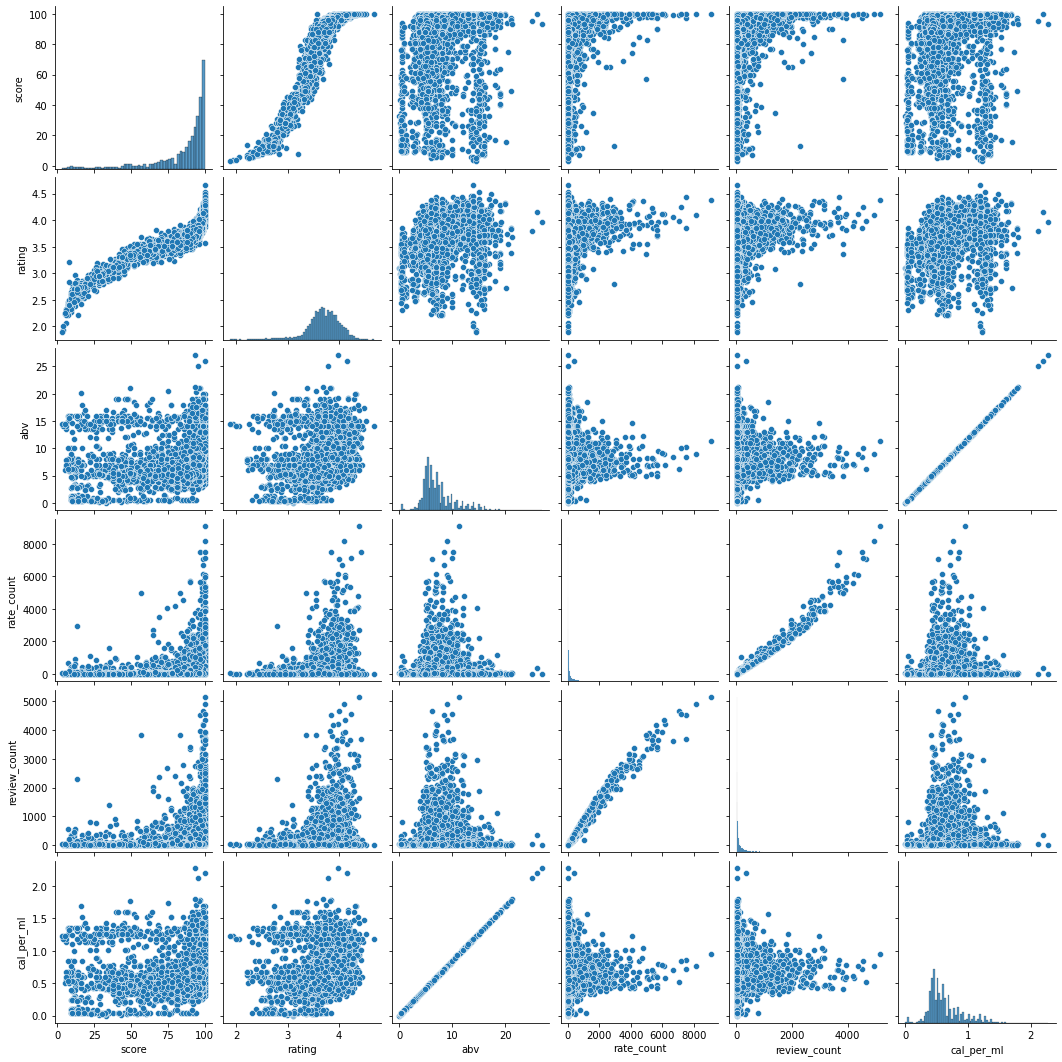

In [51]:
sns.pairplot(df)

In [53]:
pd.unique(df['country'])

array(['Scotland', 'Belgium', 'United States', 'Sweden', 'England',
       'Estonia', 'Canada', 'Spain', 'Czech Republic', 'New Zealand',
       'Ireland', 'Poland', 'Australia', 'Russia', 'Norway', 'Germany',
       'Hungary', 'Hong Kong', 'France', 'Denmark', 'Luxembourg', 'Italy',
       'Netherlands', 'Croatia', 'Slovakia', 'Romania', 'Japan',
       'Sri Lanka', 'Mexico', 'Switzerland', 'Finland', 'Laos', 'Brazil',
       'Greece', 'Austria', 'Wales', 'South Korea', 'Lithuania', 'Serbia',
       'Latvia', 'Ukraine', 'Iceland', 'Bulgaria', 'Slovenia', 'Chile',
       'Belarus', 'Togo', 'Philippines', 'Lebanon', 'Turkey', 'Singapore',
       'Faroe Islands', 'Egypt', 'India', 'Thailand', 'Israel',
       'North Korea', '\uf8ffüá®\uf8ffüá≥ China',
       '\uf8ffüá∞\uf8ffüá∑ South Korea', 'South Africa'], dtype=object)

In [54]:
#Change countries to major countries only
clist = ('Belgium','Canada','England','Germany','Poland','United States','Japan','Denmark','Netherlands','Sweden')
df['countrytf'] = df['country'].isin(clist)
tmask = df.countrytf == True
fmask = df.countrytf == False

dft = df[tmask]
dff = df[fmask]
dft['country_adj'] = df['country']
dff['country_adj'] = 'Other'

df2 = pd.concat([dft, dff])
print(df2)

                                                   name  score  rating   abv  \
1     https://www.ratebeer.com/beer/st-bernardus-wit...   90.0    3.63   5.5   
2     https://www.ratebeer.com/beer/the-bruery-three...  100.0    4.18  13.5   
3     https://www.ratebeer.com/beer/night-shift-bean...   97.0    3.90   6.5   
4     https://www.ratebeer.com/beer/omnipollo-siren-...  100.0    4.23  10.5   
5     https://www.ratebeer.com/beer/funky-buddha-las...  100.0    4.21  11.0   
...                                                 ...    ...     ...   ...   
6734  https://www.ratebeer.com/beer/mlinarica-frau-m...   60.0    3.44   4.8   
6763  https://www.ratebeer.com/beer/naparbier-hefewe...   81.0    3.46   5.4   
6790  https://www.ratebeer.com/beer/cbc-krystal-weis...   29.0    3.05   5.0   
6798  https://www.ratebeer.com/beer/edelweiss-weissb...   28.0    2.95   5.5   
6824  https://www.ratebeer.com/beer/pilot-ultravilot...   85.0    3.53   5.3   

                            style    St

/var/folders/d9/fr2n3s4s3rvd9f2l0yj556lm0000gq/T/ipykernel_46057/2835126540.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['country_adj'] = df['country']
/var/folders/d9/fr2n3s4s3rvd9f2l0yj556lm0000gq/T/ipykernel_46057/2835126540.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['country_adj'] = 'Other'


In [101]:
df3=df2[["score","rating","abv","Style 1","info1","info2","info3","rate_count","review_count","cal_per_ml","country_adj","tagged_hop-name","amarillo","citra","mosaic","simcoe","flavor","fruit","spice","choc_coff_van","barrel_aged","1001_beer_before_die","michael-jackson-500","collaboration"]]
df3.columns = df3.columns.to_series().apply(lambda x: x.strip())
print(df3)

      score  rating   abv    Style 1              info1    info2  \
1      90.0    3.63   5.5  Wheat Ale  Available Bottled  Unknown   
2     100.0    4.18  13.5     Porter            Unknown  Unknown   
3      97.0    3.90   6.5     Porter            Unknown  Unknown   
4     100.0    4.23  10.5     Porter            Unknown  Unknown   
5     100.0    4.21  11.0     Porter            Unknown  Unknown   
...     ...     ...   ...        ...                ...      ...   
6734   60.0    3.44   4.8  Weissbier            Unknown  Unknown   
6763   81.0    3.46   5.4  Weissbier            Unknown  Unknown   
6790   29.0    3.05   5.0  Weissbier            Unknown  Unknown   
6798   28.0    2.95   5.5  Weissbier            Unknown  Unknown   
6824   85.0    3.53   5.3  Wheat Ale            Unknown  Unknown   

                   info3  rate_count  review_count  cal_per_ml  ...   mosaic  \
1     Broad Distribution      2191.0        1693.0    0.464789  ...  missing   
2                Unknow

In [188]:
dfbase = df3[["score","review_count","abv","rate_count","cal_per_ml"]]

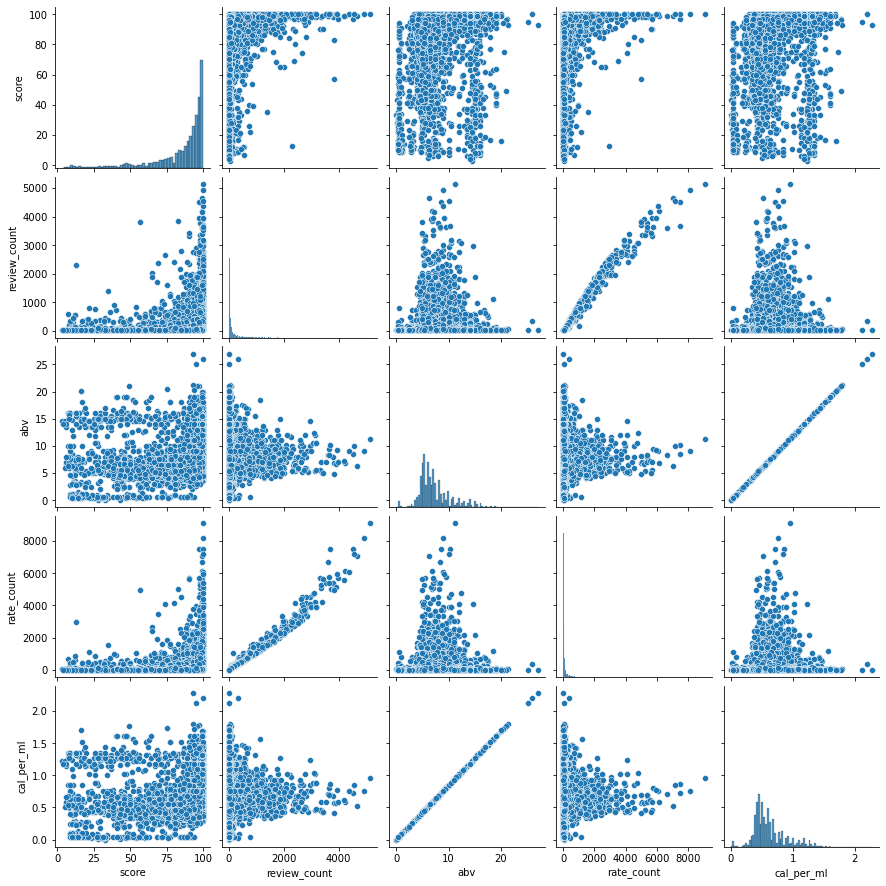

In [189]:
sns.pairplot(dfbase)

In [102]:
#Feature engineer review percent
df3["review_percent"] = df3["review_count"]/df3["rate_count"]
print(df3["review_percent"])

1       0.772707
2       0.925926
3       0.844444
4       0.847716
5       0.872247
          ...   
6734    0.857143
6763    0.833333
6790    0.768116
6798    0.840000
6824    0.774194
Name: review_percent, Length: 6722, dtype: float64


/var/folders/d9/fr2n3s4s3rvd9f2l0yj556lm0000gq/T/ipykernel_46057/219226631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["review_percent"] = df3["review_count"]/df3["rate_count"]


In [76]:
dfbase = df3[["score","review_percent","abv","rate_count"]]

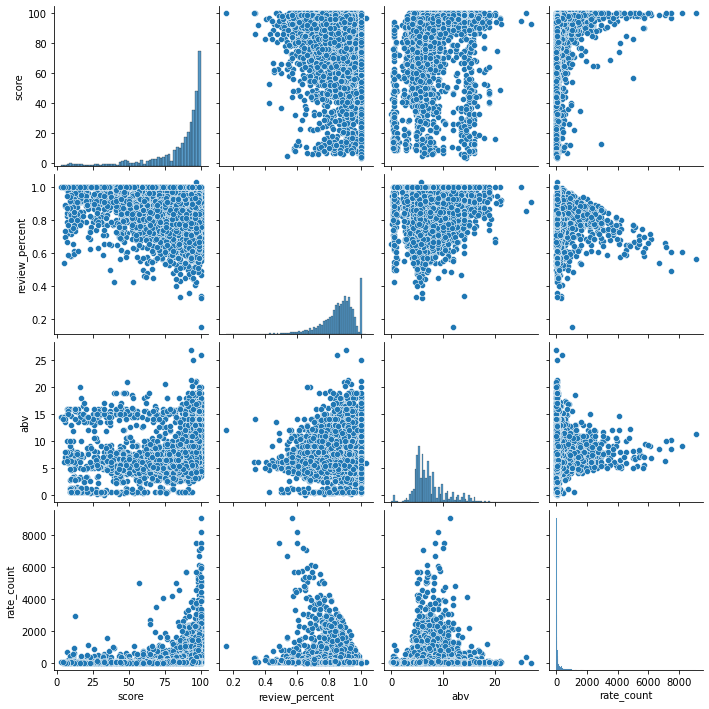

In [77]:
sns.pairplot(dfbase)

In [82]:
#X=dfbase["review_percent","abv","rate_count"]
#y=dfbase["score"]
train, test = train_test_split(dfbase, test_size=0.2, random_state=0)

In [83]:
m = LinearRegression()

m.fit(train[["review_percent","abv","rate_count"]],train["score"])

LinearRegression()

In [84]:
m.score(train[["review_percent","abv","rate_count"]],train["score"])

0.0508861020198178

In [86]:
# k-fold CV
scores = cross_val_score(m, train[["review_percent","abv","rate_count"]], train["score"], scoring='r2', cv=5)
scores   

array([0.03199177, 0.04160396, 0.06054722, 0.0622702 , 0.04479508])

In [103]:
train, test = train_test_split(df3, test_size=0.2, random_state=0)

In [114]:
dum2 = pd.get_dummies(df3[['country_adj','Style_1']])
print (dum2)

      country_adj_Belgium  country_adj_Canada  country_adj_Denmark  \
1                       1                   0                    0   
2                       0                   0                    0   
3                       0                   0                    0   
4                       0                   0                    0   
5                       0                   0                    0   
...                   ...                 ...                  ...   
6734                    0                   0                    0   
6763                    0                   0                    0   
6790                    0                   0                    0   
6798                    0                   0                    0   
6824                    0                   0                    0   

      country_adj_England  country_adj_Germany  country_adj_Japan  \
1                       0                    0                  0   
2                    

In [113]:
df3.dtypes

score                   float64
rating                  float64
abv                     float64
Style_1                  object
info1                    object
info2                    object
info3                    object
rate_count              float64
review_count            float64
cal_per_ml              float64
country_adj              object
tagged_hop-name          object
amarillo                 object
citra                    object
mosaic                   object
simcoe                   object
flavor                   object
fruit                    object
spice                    object
choc_coff_van            object
barrel_aged              object
1001_beer_before_die     object
michael-jackson-500      object
collaboration            object
review_percent          float64
dtype: object

In [115]:
dum2 = dum2.drop(['country_adj_Other', 'Style_1_Zwickelbier'], axis=1)

In [112]:
df3.rename(columns = {'Style 1':'Style_1'}, inplace = True)

/var/folders/d9/fr2n3s4s3rvd9f2l0yj556lm0000gq/T/ipykernel_46057/3298242360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.rename(columns = {'Style 1':'Style_1'}, inplace = True)


In [107]:
dum = pd.get_dummies(df3[['flavor','fruit','spice','choc_coff_van','info1','info2','info3',"tagged_hop-name","amarillo","citra","mosaic","simcoe","barrel_aged","1001_beer_before_die","collaboration"]])
print (dum)

      flavor_flavor  flavor_missing  fruit_fruit  fruit_missing  \
1                 1               0            0              1   
2                 1               0            1              0   
3                 1               0            0              1   
4                 1               0            0              1   
5                 1               0            0              1   
...             ...             ...          ...            ...   
6734              0               1            0              1   
6763              0               1            0              1   
6790              0               1            0              1   
6798              0               1            0              1   
6824              0               1            0              1   

      spice_missing  spice_spice  choc_coff_van_choc  choc_coff_van_missing  \
1                 0            1                   0                      1   
2                 1            0     

In [117]:
dum = dum.drop(['flavor_missing', "fruit_missing","spice_missing","choc_coff_van_missing","info1_Unknown","info2_Unknown","info3_Unknown","mosaic_missing","simcoe_missing","amarillo_missing","citra_missing","barrel_aged_missing","1001_beer_before_die_missing","collaboration_missing"], axis=1)

In [121]:
dum = dum.drop(['tagged_hop-name_missing','citra_ citra','mosaic_ mosaic','simcoe_ simcoe'], axis=1)

In [123]:
df3 = pd.concat([df3,dum],axis=1)
df3 = pd.concat([df3,dum2],axis=1)

In [126]:
train, test = train_test_split(df3, test_size=0.2, random_state=0)

In [128]:
pd.set_option('display.max_rows', 110)

In [129]:
train.dtypes

score                                            float64
rating                                           float64
abv                                              float64
Style_1                                           object
info1                                             object
info2                                             object
info3                                             object
rate_count                                       float64
review_count                                     float64
cal_per_ml                                       float64
country_adj                                       object
tagged_hop-name                                   object
amarillo                                          object
citra                                             object
mosaic                                            object
simcoe                                            object
flavor                                            object
fruit                          

In [130]:
m = LinearRegression()
m.fit(train[["review_percent","abv","rate_count","Style_1_Altbier"]],train["score"])
scores = cross_val_score(m, train[["review_percent","abv","rate_count","Style_1_Altbier"]], train["score"], scoring='r2', cv=5)
scores 

array([0.03198465, 0.04161002, 0.06054042, 0.06220973, 0.04479941])

In [131]:
m = LinearRegression()
m.fit(train[["review_percent","abv","rate_count","Style_1_Altbier","Style_1_Malt Liquor"]],train["score"])
scores = cross_val_score(m, train[["review_percent","abv","rate_count","Style_1_Altbier","Style_1_Malt Liquor"]], train["score"], scoring='r2', cv=5)
scores 

array([0.05681924, 0.11964714, 0.13367031, 0.13199523, 0.05874681])

In [135]:
list01 = ["review_percent","abv","rate_count",'Style_1_Altbier','Style_1_Amber Lager','Style_1_Apple Cider','Style_1_Barley Wine / Wheat Wine / Rye Wine','Style_1_Belgian Ale','Style_1_Berliner Weisse','Style_1_Bire de Garde / de Mars / Brut','Style_1_Bitter','Style_1_Black Lager','Style_1_Blonde Ale / Golden Ale','Style_1_Bock','Style_1_Brown Ale','Style_1_California Common / Steam Beer','Style_1_Cream Ale','Style_1_Dark Lager - Dunkel','Style_1_Dubbel','Style_1_Flavored','Style_1_Gose','Style_1_Gotlandsdricka / Kodu√µlu / Sahti','Style_1_Grodziskie / Gr√§tzer / Lichtenhainer','Style_1_Gruit','Style_1_Helles / Dortmunder Export','Style_1_IPA','Style_1_Kvass','Style_1_K√∂lsch / K√∂lsch-Style','Style_1_Lambic','Style_1_Low / No Alcohol','Style_1_Malt Liquor','Style_1_Mead','Style_1_Mild Ale','Style_1_M√§rzen / Oktoberfest Bier','Style_1_Old Ale','Style_1_Pale Ale','Style_1_Pale Lager','Style_1_Perry','Style_1_Pilsener','Style_1_Porter','Style_1_Quadrupel','Style_1_Radler / Shandy','Style_1_Red Ale','Style_1_Saison','Style_1_Sake','Style_1_Scotch Ale','Style_1_Smoked','Style_1_Sour','Style_1_Specialty Grain','Style_1_Stout','Style_1_Strong Ale','Style_1_Traditional Ale','Style_1_Tripel','Style_1_Weissbier','Style_1_Wheat Ale']

In [136]:
#Add Styles
m = LinearRegression()
m.fit(train[list01],train["score"])
scores = cross_val_score(m, train[list01], train["score"], scoring='r2', cv=5)
scores

array([0.57168753, 0.64450657, 0.62671669, 0.58667242, 0.62224674])

In [137]:
list02 = ["review_percent","abv","rate_count",'country_adj_Belgium','country_adj_Canada','country_adj_Denmark','country_adj_England','country_adj_Germany','country_adj_Japan','country_adj_Netherlands','country_adj_Poland','country_adj_Sweden','country_adj_United States']

In [138]:
#Add Countries
m = LinearRegression()
m.fit(train[list02],train["score"])
scores = cross_val_score(m, train[list02], train["score"], scoring='r2', cv=5)
scores

array([0.15253613, 0.22761201, 0.2309709 , 0.17459741, 0.28114238])

In [140]:
list03 = ["review_percent","abv","rate_count",'flavor_flavor','barrel_aged_barrel_aged','1001_beer_before_die_1001_beer_before_die','collaboration_collaboration','tagged_hop-name_hops']

In [141]:
#Add Other non linear features
m = LinearRegression()
m.fit(train[list03],train["score"])
scores = cross_val_score(m, train[list03], train["score"], scoring='r2', cv=5)
scores

array([0.11609351, 0.11507519, 0.11397929, 0.12795039, 0.12984385])

In [142]:
list04 = ["review_percent","abv","rate_count",'barrel_aged_barrel_aged','1001_beer_before_die_1001_beer_before_die','1001_beer_before_die_1001_beer_before_die','collaboration_collaboration','amarillo_amarillo','citra_citra','mosaic_mosaic','simcoe_simcoe','fruit_fruit','spice_spice']

In [143]:
#Add Other+ non linear features
m = LinearRegression()
m.fit(train[list04],train["score"])
scores = cross_val_score(m, train[list04], train["score"], scoring='r2', cv=5)
scores

array([0.11504179, 0.10098707, 0.11199729, 0.12348417, 0.12334106])

In [144]:
list05 = ["review_percent","abv","rate_count",'Style_1_Altbier','Style_1_Amber Lager','Style_1_Apple Cider','Style_1_Barley Wine / Wheat Wine / Rye Wine','Style_1_Belgian Ale','Style_1_Berliner Weisse','Style_1_Bire de Garde / de Mars / Brut','Style_1_Bitter','Style_1_Black Lager','Style_1_Blonde Ale / Golden Ale','Style_1_Bock','Style_1_Brown Ale','Style_1_California Common / Steam Beer','Style_1_Cream Ale','Style_1_Dark Lager - Dunkel','Style_1_Dubbel','Style_1_Flavored','Style_1_Gose','Style_1_Gotlandsdricka / Kodu√µlu / Sahti','Style_1_Grodziskie / Gr√§tzer / Lichtenhainer','Style_1_Gruit','Style_1_Helles / Dortmunder Export','Style_1_IPA','Style_1_Kvass','Style_1_K√∂lsch / K√∂lsch-Style','Style_1_Lambic','Style_1_Low / No Alcohol','Style_1_Malt Liquor','Style_1_Mead','Style_1_Mild Ale','Style_1_M√§rzen / Oktoberfest Bier','Style_1_Old Ale','Style_1_Pale Ale','Style_1_Pale Lager','Style_1_Perry','Style_1_Pilsener','Style_1_Porter','Style_1_Quadrupel','Style_1_Radler / Shandy','Style_1_Red Ale','Style_1_Saison','Style_1_Sake','Style_1_Scotch Ale','Style_1_Smoked','Style_1_Sour','Style_1_Specialty Grain','Style_1_Stout','Style_1_Strong Ale','Style_1_Traditional Ale','Style_1_Tripel','Style_1_Weissbier','Style_1_Wheat Ale','country_adj_Belgium','country_adj_Canada','country_adj_Denmark','country_adj_England','country_adj_Germany','country_adj_Japan','country_adj_Netherlands','country_adj_Poland','country_adj_Sweden','country_adj_United States']

In [146]:
#Add Style and Country
m = LinearRegression()
m.fit(train[list05],train["score"])
scores = cross_val_score(m, train[list05], train["score"], scoring='r2', cv=5)
scores

array([0.57483833, 0.65912126, 0.63722243, 0.59654104, 0.63116905])

In [147]:
list06 = ['Style_1_Altbier','Style_1_Amber Lager','Style_1_Apple Cider','Style_1_Barley Wine / Wheat Wine / Rye Wine','Style_1_Belgian Ale','Style_1_Berliner Weisse','Style_1_Bire de Garde / de Mars / Brut','Style_1_Bitter','Style_1_Black Lager','Style_1_Blonde Ale / Golden Ale','Style_1_Bock','Style_1_Brown Ale','Style_1_California Common / Steam Beer','Style_1_Cream Ale','Style_1_Dark Lager - Dunkel','Style_1_Dubbel','Style_1_Flavored','Style_1_Gose','Style_1_Gotlandsdricka / Kodu√µlu / Sahti','Style_1_Grodziskie / Gr√§tzer / Lichtenhainer','Style_1_Gruit','Style_1_Helles / Dortmunder Export','Style_1_IPA','Style_1_Kvass','Style_1_K√∂lsch / K√∂lsch-Style','Style_1_Lambic','Style_1_Low / No Alcohol','Style_1_Malt Liquor','Style_1_Mead','Style_1_Mild Ale','Style_1_M√§rzen / Oktoberfest Bier','Style_1_Old Ale','Style_1_Pale Ale','Style_1_Pale Lager','Style_1_Perry','Style_1_Pilsener','Style_1_Porter','Style_1_Quadrupel','Style_1_Radler / Shandy','Style_1_Red Ale','Style_1_Saison','Style_1_Sake','Style_1_Scotch Ale','Style_1_Smoked','Style_1_Sour','Style_1_Specialty Grain','Style_1_Stout','Style_1_Strong Ale','Style_1_Traditional Ale','Style_1_Tripel','Style_1_Weissbier','Style_1_Wheat Ale','country_adj_Belgium','country_adj_Canada','country_adj_Denmark','country_adj_England','country_adj_Germany','country_adj_Japan','country_adj_Netherlands','country_adj_Poland','country_adj_Sweden','country_adj_United States']

In [148]:
#Only Style and Country no linear features
m = LinearRegression()
m.fit(train[list06],train["score"])
scores = cross_val_score(m, train[list06], train["score"], scoring='r2', cv=5)
scores

array([0.56250493, 0.65208679, 0.62137158, 0.57477276, 0.6147001 ])

In [151]:
list07 = ['abv','rate_count','review_percent','flavor_flavor','fruit_fruit','spice_spice','choc_coff_van_choc','info1_Available Bottled','info2_Available On Tap','info3_Broad Distribution','info3_Regional Distribution','tagged_hop-name_hops','amarillo_amarillo','citra_citra','mosaic_mosaic','simcoe_simcoe','barrel_aged_barrel_aged','1001_beer_before_die_1001_beer_before_die','collaboration_collaboration','country_adj_Belgium','country_adj_Canada','country_adj_Denmark','country_adj_England','country_adj_Germany','country_adj_Japan','country_adj_Netherlands','country_adj_Poland','country_adj_Sweden','country_adj_United States','Style_1_Altbier','Style_1_Amber Lager','Style_1_Apple Cider','Style_1_Barley Wine / Wheat Wine / Rye Wine','Style_1_Belgian Ale','Style_1_Berliner Weisse','Style_1_Bire de Garde / de Mars / Brut','Style_1_Bitter','Style_1_Black Lager','Style_1_Blonde Ale / Golden Ale','Style_1_Bock','Style_1_Brown Ale','Style_1_California Common / Steam Beer','Style_1_Cream Ale','Style_1_Dark Lager - Dunkel','Style_1_Dubbel','Style_1_Flavored','Style_1_Gose','Style_1_Gotlandsdricka / Kodu√µlu / Sahti','Style_1_Grodziskie / Gr√§tzer / Lichtenhainer','Style_1_Gruit','Style_1_Helles / Dortmunder Export','Style_1_IPA','Style_1_Kvass','Style_1_K√∂lsch / K√∂lsch-Style','Style_1_Lambic','Style_1_Low / No Alcohol','Style_1_Malt Liquor','Style_1_Mead','Style_1_Mild Ale','Style_1_M√§rzen / Oktoberfest Bier','Style_1_Old Ale','Style_1_Pale Ale','Style_1_Pale Lager','Style_1_Perry','Style_1_Pilsener','Style_1_Porter','Style_1_Quadrupel','Style_1_Radler / Shandy','Style_1_Red Ale','Style_1_Saison','Style_1_Sake','Style_1_Scotch Ale','Style_1_Smoked','Style_1_Sour','Style_1_Specialty Grain','Style_1_Stout','Style_1_Strong Ale','Style_1_Traditional Ale','Style_1_Tripel','Style_1_Weissbier','Style_1_Wheat Ale']

In [152]:
#Added Style, Country, and Other+ **This is the best fit model**
m = LinearRegression()
m.fit(train[list07],train["score"])
scores = cross_val_score(m, train[list07], train["score"], scoring='r2', cv=5)
scores

array([0.58496858, 0.66173404, 0.64210473, 0.60407008, 0.63554315])

In [153]:
#Test data score for best model
m.score(test[list07],test['score'])

0.5407499508024735

In [165]:
#Ridge
alphas = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphas, cv=5)
results = ridge_model.fit(train[list07], train["score"])

In [166]:
scores = cross_val_score(ridge_model, train[list07], train["score"], scoring='r2', cv=5)
scores

array([0.58499305, 0.66171354, 0.64208619, 0.6040616 , 0.63561585])

In [167]:
#Lasso
alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
results2 = lasso_model.fit(train[list07], train["score"])

In [168]:
scores = cross_val_score(lasso_model, train[list07], train["score"], scoring='r2', cv=5)
scores

array([0.58155861, 0.65843509, 0.64089328, 0.60393613, 0.63466827])

In [170]:
#Elastic Net
alphas = [.0001,.01,.1,.3,.5,.7,1]
l1_rats = [.1,.5,.7,.9,.95,.99,1]
enet_model = ElasticNetCV(alphas = alphas, l1_ratio = l1_rats, cv = 5)
results3 = enet_model.fit(train[list07], train["score"])

In [171]:
scores = cross_val_score(enet_model, train[list07], train["score"], scoring='r2', cv=5)
scores

/Users/matthew.redmond@usfoods.com/opt/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182.43131762871053, tolerance: 142.90399494333042
  model = cd_fast.enet_coordinate_descent_gram(
/Users/matthew.redmond@usfoods.com/opt/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.62600602465682, tolerance: 139.30549183139536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/matthew.redmond@usfoods.com/opt/anaconda3/envs/regression/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.03073766070884, tolerance: 141.9

array([0.58500968, 0.66170443, 0.64204381, 0.60405273, 0.63560323])

In [172]:
#Look at Variance Inflation Factor
#FROM https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
vifs = pd.Series(np.linalg.inv(train[list07].corr().to_numpy()).diagonal(), 
                 index=train[list07].columns, 
                 name='VIF')

In [173]:
print(vifs)

abv                                               2.867216
rate_count                                        1.994655
review_percent                                    1.636884
flavor_flavor                                     5.135387
fruit_fruit                                       2.993196
spice_spice                                       1.824430
choc_coff_van_choc                                1.920935
info1_Available Bottled                           1.455410
info2_Available On Tap                            1.228553
info3_Broad Distribution                          1.403981
info3_Regional Distribution                       1.115907
tagged_hop-name_hops                              1.651536
amarillo_amarillo                                 1.239104
citra_citra                                       1.277024
mosaic_mosaic                                     1.060826
simcoe_simcoe                                     1.024606
barrel_aged_barrel_aged                           1.4334

In [174]:
list08 = ['abv','rate_count','review_percent','fruit_fruit','spice_spice','choc_coff_van_choc','info1_Available Bottled','info2_Available On Tap','info3_Broad Distribution','info3_Regional Distribution','tagged_hop-name_hops','amarillo_amarillo','citra_citra','mosaic_mosaic','simcoe_simcoe','barrel_aged_barrel_aged','1001_beer_before_die_1001_beer_before_die','collaboration_collaboration','country_adj_Belgium','country_adj_Canada','country_adj_Denmark','country_adj_England','country_adj_Germany','country_adj_Japan','country_adj_Netherlands','country_adj_Poland','country_adj_Sweden','country_adj_United States','Style_1_Altbier','Style_1_Amber Lager','Style_1_Apple Cider','Style_1_Barley Wine / Wheat Wine / Rye Wine','Style_1_Belgian Ale','Style_1_Berliner Weisse','Style_1_Bire de Garde / de Mars / Brut','Style_1_Bitter','Style_1_Black Lager','Style_1_Blonde Ale / Golden Ale','Style_1_Bock','Style_1_Brown Ale','Style_1_California Common / Steam Beer','Style_1_Cream Ale','Style_1_Dark Lager - Dunkel','Style_1_Dubbel','Style_1_Flavored','Style_1_Gose','Style_1_Gotlandsdricka / Kodu√µlu / Sahti','Style_1_Grodziskie / Gr√§tzer / Lichtenhainer','Style_1_Gruit','Style_1_Helles / Dortmunder Export','Style_1_IPA','Style_1_Kvass','Style_1_K√∂lsch / K√∂lsch-Style','Style_1_Lambic','Style_1_Low / No Alcohol','Style_1_Malt Liquor','Style_1_Mead','Style_1_Mild Ale','Style_1_M√§rzen / Oktoberfest Bier','Style_1_Old Ale','Style_1_Pale Ale','Style_1_Pale Lager','Style_1_Perry','Style_1_Pilsener','Style_1_Porter','Style_1_Quadrupel','Style_1_Radler / Shandy','Style_1_Red Ale','Style_1_Saison','Style_1_Sake','Style_1_Scotch Ale','Style_1_Smoked','Style_1_Sour','Style_1_Specialty Grain','Style_1_Stout','Style_1_Strong Ale','Style_1_Traditional Ale','Style_1_Tripel','Style_1_Weissbier','Style_1_Wheat Ale']

In [176]:
#FROM https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
vifs = pd.Series(np.linalg.inv(train[list08].corr().to_numpy()).diagonal(), 
                 index=train[list08].columns, 
                 name='VIF')
print(vifs)

abv                                               2.866865
rate_count                                        1.994549
review_percent                                    1.633899
fruit_fruit                                       1.167541
spice_spice                                       1.230749
choc_coff_van_choc                                1.168564
info1_Available Bottled                           1.455401
info2_Available On Tap                            1.228492
info3_Broad Distribution                          1.403526
info3_Regional Distribution                       1.115906
tagged_hop-name_hops                              1.650616
amarillo_amarillo                                 1.238922
citra_citra                                       1.276186
mosaic_mosaic                                     1.060749
simcoe_simcoe                                     1.024544
barrel_aged_barrel_aged                           1.433250
1001_beer_before_die_1001_beer_before_die         1.3816

In [177]:
list09 = ['abv','rate_count','review_percent','fruit_fruit','spice_spice','choc_coff_van_choc','info1_Available Bottled','info2_Available On Tap','info3_Broad Distribution','info3_Regional Distribution','tagged_hop-name_hops','amarillo_amarillo','citra_citra','mosaic_mosaic','simcoe_simcoe','barrel_aged_barrel_aged','1001_beer_before_die_1001_beer_before_die','collaboration_collaboration','country_adj_Belgium','country_adj_Canada','country_adj_Denmark','country_adj_England','country_adj_Germany','country_adj_Japan','country_adj_Netherlands','country_adj_Poland','country_adj_Sweden','country_adj_United States','Style_1_Altbier','Style_1_Amber Lager','Style_1_Apple Cider','Style_1_Barley Wine / Wheat Wine / Rye Wine','Style_1_Belgian Ale','Style_1_Berliner Weisse','Style_1_Bire de Garde / de Mars / Brut','Style_1_Bitter','Style_1_Black Lager','Style_1_Blonde Ale / Golden Ale','Style_1_Bock','Style_1_Brown Ale','Style_1_California Common / Steam Beer','Style_1_Cream Ale','Style_1_Dark Lager - Dunkel','Style_1_Dubbel','Style_1_Flavored','Style_1_Gose','Style_1_Gotlandsdricka / Kodu√µlu / Sahti','Style_1_Grodziskie / Gr√§tzer / Lichtenhainer','Style_1_Gruit','Style_1_Helles / Dortmunder Export','Style_1_Kvass','Style_1_K√∂lsch / K√∂lsch-Style','Style_1_Lambic','Style_1_Low / No Alcohol','Style_1_Malt Liquor','Style_1_Mead','Style_1_Mild Ale','Style_1_M√§rzen / Oktoberfest Bier','Style_1_Old Ale','Style_1_Pale Lager','Style_1_Perry','Style_1_Pilsener','Style_1_Porter','Style_1_Quadrupel','Style_1_Radler / Shandy','Style_1_Red Ale','Style_1_Saison','Style_1_Scotch Ale','Style_1_Smoked','Style_1_Sour','Style_1_Specialty Grain','Style_1_Strong Ale','Style_1_Traditional Ale','Style_1_Tripel','Style_1_Weissbier','Style_1_Wheat Ale']

In [179]:
#FROM https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
vifs = pd.Series(np.linalg.inv(train[list09].corr().to_numpy()).diagonal(), 
                 index=train[list09].columns, 
                 name='VIF')
print(vifs)

abv                                              2.268986
rate_count                                       1.976770
review_percent                                   1.598669
fruit_fruit                                      1.163589
spice_spice                                      1.230625
choc_coff_van_choc                               1.120438
info1_Available Bottled                          1.452699
info2_Available On Tap                           1.226160
info3_Broad Distribution                         1.397649
info3_Regional Distribution                      1.113307
tagged_hop-name_hops                             1.600387
amarillo_amarillo                                1.235095
citra_citra                                      1.268111
mosaic_mosaic                                    1.060456
simcoe_simcoe                                    1.022747
barrel_aged_barrel_aged                          1.376925
1001_beer_before_die_1001_beer_before_die        1.380897
collaboration_

In [180]:
#Removing features makes rscore worse
m = LinearRegression()
m.fit(train[list09],train["score"])
scores = cross_val_score(m, train[list09], train["score"], scoring='r2', cv=5)
scores

array([0.47496211, 0.58002323, 0.56446509, 0.46963717, 0.54614661])

In [181]:
##Removing features makes rscore worse
m = LinearRegression()
m.fit(train[list08],train["score"])
scores = cross_val_score(m, train[list08], train["score"], scoring='r2', cv=5)
scores

array([0.58496593, 0.66167683, 0.64229864, 0.60401611, 0.63569809])

In [185]:
#List07 model is the best fit Look at MAE
m = LinearRegression()
m.fit(train[list07],train["score"])
scores = cross_val_score(m, train[list07], train["score"], scoring='neg_mean_absolute_error', cv=5)
scores

array([-8.31046496, -7.57247176, -8.02351542, -8.32946283, -8.25241385])

In [190]:
#List07 model is the best fit Look at RMSE
m = LinearRegression()
m.fit(train[list07],train["score"])
scores = cross_val_score(m, train[list07], train["score"], scoring='neg_root_mean_squared_error', cv=5)
scores

array([-12.98849248, -11.31832093, -12.25992851, -12.57556485,
       -12.47572546])

In [187]:
#Use test data for List07
m.score(test[list07],test['score'])

0.5407499508024735